In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
def max_freq_decorrelation(
    freq_resolution_hz,
    max_bl_length_m,
    source_za = np.pi/2,
    c = 3e8,
):
    return 1 - np.sinc(
        freq_resolution_hz * max_bl_length_m / c * np.sin(source_za)
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)


def time_decorrelation(
    time_resolution_s,
    freq_hz,
    bl_ew_extent_m,
    bl_ns_extent_m,
    source_ra_offset_hr,  # Difference between zenith and source RAs
    source_dec_deg,  # Difference between zenith and source RAs
    telescope_lat_deg=39.25,
    omega=7.27e-5,
    c=3e8,
):
    source_dec_rad = np.deg2rad(source_dec_deg)
    source_ra_offset_rad = source_ra_offset_hr / 12 * np.pi
    zenith_dec_rad = np.deg2rad(telescope_lat_deg)
    u = bl_ew_extent_m * freq_hz / c
    v = bl_ns_extent_m * freq_hz / c
    sinc_arg = (
        time_resolution_s
        * omega
        * np.cos(source_dec_rad)
        * (
            u * np.cos(source_ra_offset_rad)
            - v * np.sin(zenith_dec_rad) * np.sin(source_ra_offset_rad)
        )
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)
    return 1 - np.sinc(sinc_arg)


def time_decorrelation_with_continuous_phase_tracking(
    time_resolution_s,
    freq_hz,
    bl_ew_extent_m,
    bl_ns_extent_m,
    source_ra_offset_hr,  # Difference between zenith and source RAs
    source_dec_deg,  # Difference between zenith and source RAs
    telescope_lat_deg=39.25,
    omega=7.27e-5,
    c=3e8,
):
    source_dec_rad = np.deg2rad(source_dec_deg)
    source_ra_offset_rad = source_ra_offset_hr / 12 * np.pi
    zenith_dec_rad = np.deg2rad(telescope_lat_deg)
    u = bl_ew_extent_m * freq_hz / c
    v = bl_ns_extent_m * freq_hz / c
    sinc_arg = (
        time_resolution_s
        * omega
        * np.cos(source_dec_rad)
        * (
            -1 * u * np.cos(zenith_dec_rad)
            + u * np.cos(source_ra_offset_rad)
            - v * np.sin(zenith_dec_rad) * np.sin(source_ra_offset_rad)
        )
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)
    return 1 - np.sinc(sinc_arg)


def time_decorrelation_with_discrete_phase_tracking(
    total_time_interval_s,
    phase_tracking_interval_s,
    freq_hz,
    bl_ew_extent_m,
    bl_ns_extent_m,
    source_ra_offset_hr,  # Difference between zenith and source RAs
    source_dec_deg,  # Difference between zenith and source RAs
    telescope_lat_deg=39.25,
    omega=7.27e-5,
    c=3e8,
):
    source_dec_rad = np.deg2rad(source_dec_deg)
    source_ra_offset_rad = source_ra_offset_hr / 12 * np.pi
    zenith_dec_rad = np.deg2rad(telescope_lat_deg)
    u = bl_ew_extent_m * freq_hz / c
    v = bl_ns_extent_m * freq_hz / c

    time_steps = int(np.floor((total_time_interval_s / phase_tracking_interval_s - 1)/2)*2 +1)
    n_array = np.linspace(
        -(time_steps - 1) / 2,
        (time_steps - 1) / 2, num=time_steps
    )

    sinc_arg = (
        phase_tracking_interval_s
        * omega
        * np.cos(source_dec_rad)
        * (
            u * np.cos(source_ra_offset_rad)
            - v * np.sin(zenith_dec_rad) * np.sin(source_ra_offset_rad)
        )
    )  # Note that the numpy sinc function is \sin(\pi x)/(\pi x)
    exp_term = 0
    for n in n_array:
        exp_term += np.exp((2 * np.pi * 1j * n * omega) * (
            u * np.cos(source_dec_rad) * np.cos(source_ra_offset_rad)
            - u * np.cos(zenith_dec_rad)
            - v
            * np.cos(source_dec_rad)
            * np.sin(zenith_dec_rad)
            * np.sin(source_ra_offset_rad)
        ))
    decorr = 1 - np.real(exp_term) * np.sinc(sinc_arg)

    return decorr

In [33]:
np.deg2rad(10)

0.17453292519943295

In [35]:
freq_resolution_hz = 130e3
time_resolution_s = 1.5
max_bl_length_m = 15e3
freq_hz = 250e6

In [30]:
source_zas = np.linspace(0, np.pi/2, 100)
decorr_values_15km = max_freq_decorrelation(
    freq_resolution_hz, 15000, source_za=source_zas
)
decorr_values_7km = max_freq_decorrelation(
    freq_resolution_hz, 7000, source_za=source_zas
)

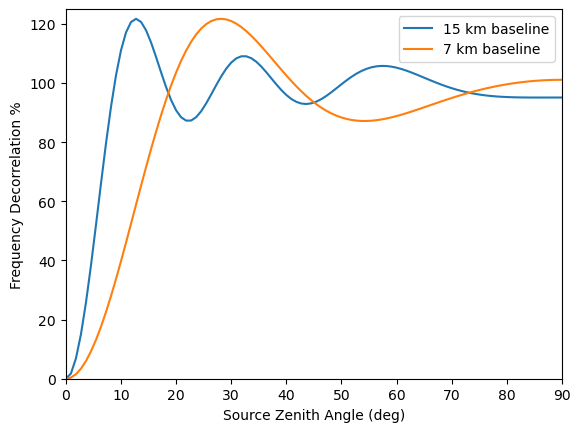

In [32]:
plt.plot(source_zas / np.pi * 180, decorr_values_15km * 100, label="15 km baseline")
plt.plot(source_zas / np.pi * 180, decorr_values_7km * 100, label="7 km baseline")
plt.xlim(0, 90)
plt.ylim(0, 125)
plt.xlabel("Source Zenith Angle (deg)")
plt.ylabel("Frequency Decorrelation %")
plt.legend()
plt.show()

In [ ]:
source_ra_offset_list = np.linspace(-6, 6, num=200)
source_dec_deg_list = np.linspace(39.25 - 90, 90, num=200)
source_ra_offset_hrs, source_dec_degs = np.meshgrid(source_ra_offset_list, source_dec_deg_list)

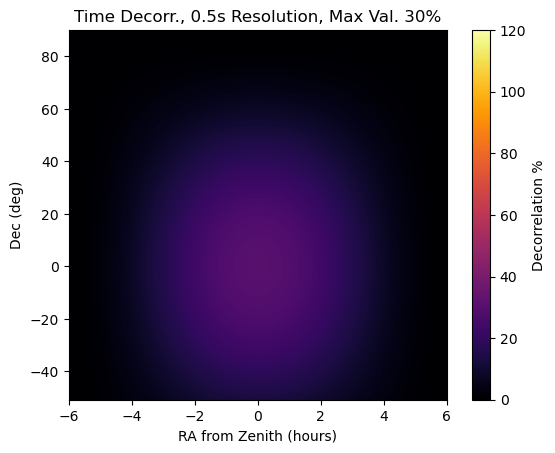

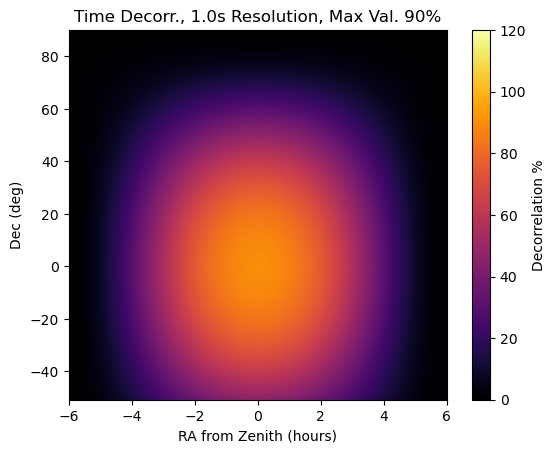

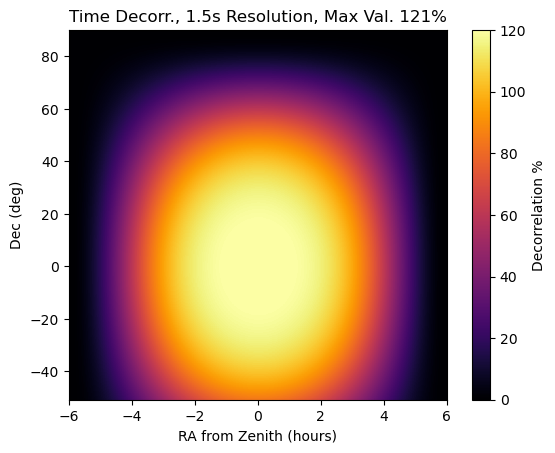

In [71]:
for use_time_resolution_s in np.linspace(0.5, 1.5, num=3):

    decorr_values = time_decorrelation(
        use_time_resolution_s,
        freq_hz,
        15e3,
        0,
        source_ra_offset_hrs,  # Difference between zenith and source RAs
        source_dec_degs,  # Difference between zenith and source RAs
        telescope_lat_deg=39.25,
        omega=7.27e-5,
        c=3e8,
    )

    plt.imshow(
        decorr_values*100,
        origin="lower",
        cmap="inferno",
        interpolation=None,
        extent=(
            np.min(source_ra_offset_list),
            np.max(source_ra_offset_list),
            np.min(source_dec_deg_list),
            np.max(source_dec_deg_list),
        ),
        vmin=0,
        vmax=120,
        aspect=1/12,
    )
    plt.xlabel("RA from Zenith (hours)")
    plt.ylabel("Dec (deg)")
    plt.colorbar(label="Decorrelation %")
    plt.title(
        f"Time Decorr., {use_time_resolution_s}s Resolution, Max Val. {int(np.max(decorr_values*100))}%"
    )
    plt.show()
    #plt.savefig(f"/Users/ruby/Downloads/time_decorr_{use_time_resolution_s}s.png",dpi=300)
    #plt.close()

In [60]:
print(np.max(decorr_values))

1.2122491090854237


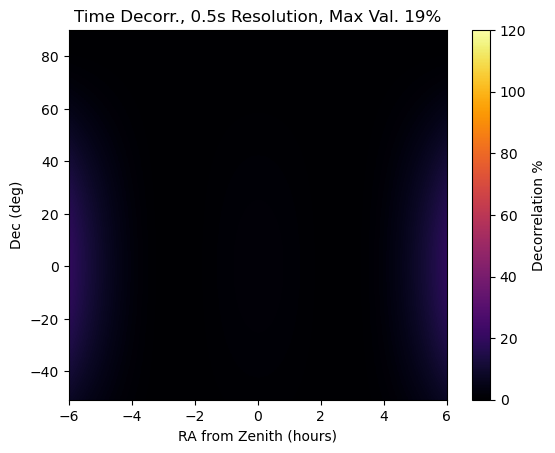

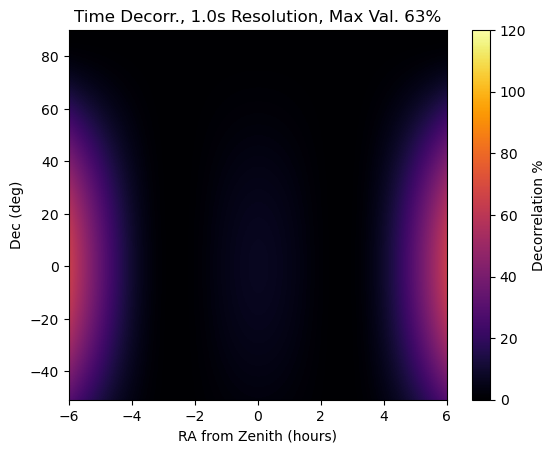

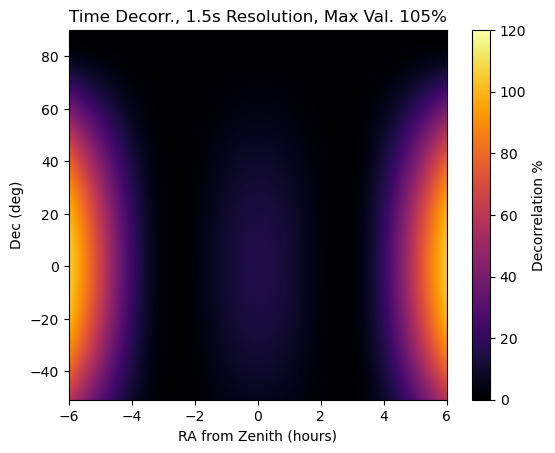

In [82]:
for use_time_resolution_s in np.linspace(0.5, 1.5, num=3):

    decorr_values = time_decorrelation_with_continuous_phase_tracking(
        use_time_resolution_s,
        freq_hz,
        15e3,
        0,
        source_ra_offset_hrs,  # Difference between zenith and source RAs
        source_dec_degs,  # Difference between zenith and source RAs
        telescope_lat_deg=39.25,
        omega=7.27e-5,
        c=3e8,
    )

    plt.imshow(
        decorr_values * 100,
        origin="lower",
        cmap="inferno",
        interpolation=None,
        extent=(
            np.min(source_ra_offset_list),
            np.max(source_ra_offset_list),
            np.min(source_dec_deg_list),
            np.max(source_dec_deg_list),
        ),
        vmin=0,
        vmax=120,
        aspect=1 / 12,
    )
    plt.xlabel("RA from Zenith (hours)")
    plt.ylabel("Dec (deg)")
    plt.colorbar(label="Decorrelation %")
    plt.title(
        f"Time Decorr., {use_time_resolution_s}s Resolution, Max Val. {int(np.max(decorr_values*100))}%"
    )
    plt.show()
    # plt.savefig(f"/Users/ruby/Downloads/time_decorr_{use_time_resolution_s}s.png",dpi=300)
    # plt.close()

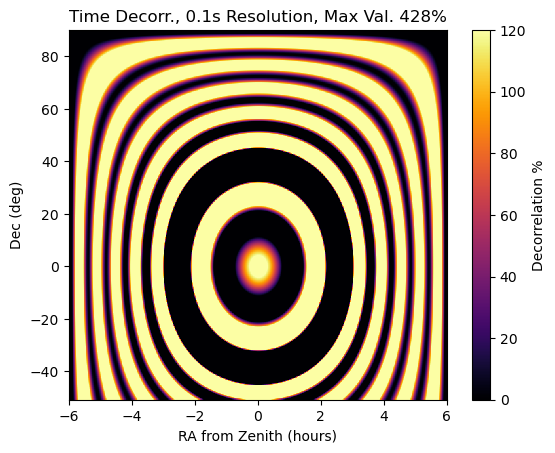

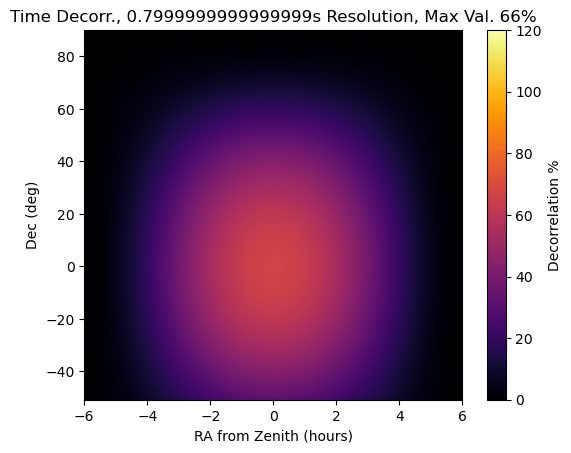

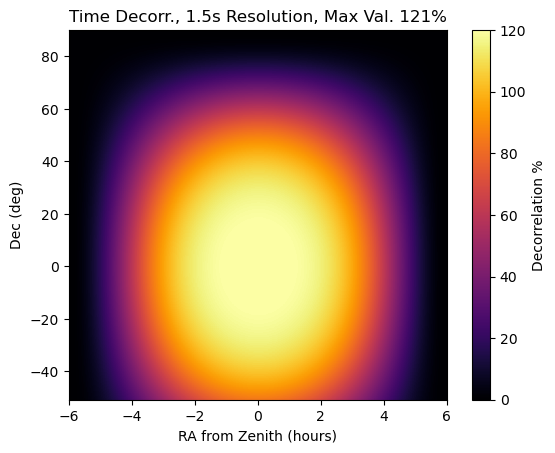

In [96]:
total_time_interval_s = 1.5
for use_phase_tracking_interval_s in np.linspace(0.1, 1.5, num=3):
    decorr_values = time_decorrelation_with_discrete_phase_tracking(
        total_time_interval_s,
        use_phase_tracking_interval_s,
        freq_hz,
        15e3,
        0,
        source_ra_offset_hrs,  # Difference between zenith and source RAs
        source_dec_degs,  # Difference between zenith and source RAs
        telescope_lat_deg=39.25,
        omega=7.27e-5,
        c=3e8,
    )

    plt.imshow(
        decorr_values * 100,
        origin="lower",
        cmap="inferno",
        interpolation=None,
        extent=(
            np.min(source_ra_offset_list),
            np.max(source_ra_offset_list),
            np.min(source_dec_deg_list),
            np.max(source_dec_deg_list),
        ),
        vmin=0,
        vmax=120,
        aspect=1 / 12,
    )
    plt.xlabel("RA from Zenith (hours)")
    plt.ylabel("Dec (deg)")
    plt.colorbar(label="Decorrelation %")
    plt.title(
        f"Time Decorr., {use_phase_tracking_interval_s}s Resolution, Max Val. {int(np.max(decorr_values*100))}%"
    )
    plt.show()